In [18]:
import torch 
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

# **Exploración.**

In [20]:
train = torchvision.datasets.VOCDetection('./data', download=True)

len(train)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


5717

In [21]:
classes = ["background",
            "aeroplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "diningtable",
            "dog",
            "horse",
            "motorbike",
            "person",
            "pottedplant",
            "sheep",
            "sofa",
            "train",
            "tvmonitor"]

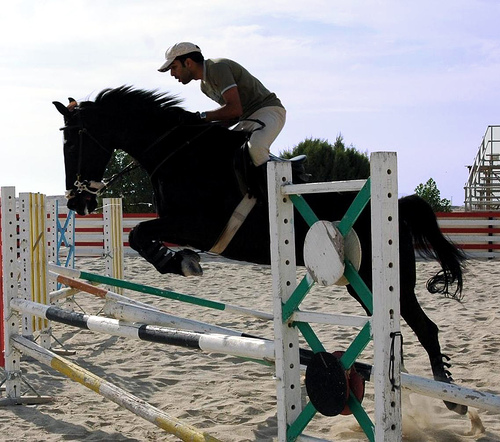

In [22]:
img, label = train[0]

img

In [23]:
label

{'annotation': {'filename': '2008_000008.jpg',
  'folder': 'VOC2012',
  'object': [{'bndbox': {'xmax': '471',
     'xmin': '53',
     'ymax': '420',
     'ymin': '87'},
    'difficult': '0',
    'name': 'horse',
    'occluded': '1',
    'pose': 'Left',
    'truncated': '0'},
   {'bndbox': {'xmax': '289', 'xmin': '158', 'ymax': '167', 'ymin': '44'},
    'difficult': '0',
    'name': 'person',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '1'}],
  'segmented': '0',
  'size': {'depth': '3', 'height': '442', 'width': '500'},
  'source': {'annotation': 'PASCAL VOC2008',
   'database': 'The VOC2008 Database',
   'image': 'flickr'}}}

In [24]:
def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

# **Imagen de Entrenamiento.**

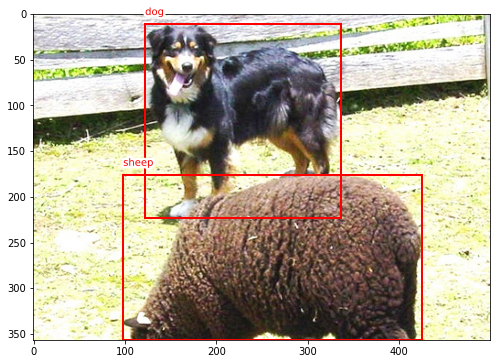

In [25]:
img_np, anns = get_sample(21)
plot_anns(img_np, anns)
plt.show()

# **Modelo.**

In [26]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

In [27]:
class Model(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=4):
    super().__init__()
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.fc1 = block2(64*6*6, 100)
    self.fc2 = torch.nn.Linear(100, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

# **Preprocessing.**

In [28]:
import albumentations as A

# with coco format the bb is expected in 
# [x_min, y_min, width, height] 
def get_aug(aug, min_area=0., min_visibility=0.):
    return A.Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['labels']})

trans = get_aug([A.Resize(100, 100)])

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

img.shape, bbs

((100, 100, 3),
 [[24.4, 3.081232492997199, 42.800000000000004, 59.383753501400555],
  [19.6, 49.299719887955185, 65.4, 50.700280112044815]])

In [29]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

In [30]:
bb = bbs[0]
bb_norm = norm(bb, img.shape[:2])

# **Entrenamiento.**

In [31]:
def fit(model, X, y, epochs=1, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.L1Loss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = []
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

In [32]:
model = Model()
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0)
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0)
fit(model, img_tensor, bb_tensor, epochs=30)

Epoch 1/30 loss 0.37604
Epoch 2/30 loss 0.32882
Epoch 3/30 loss 0.26960
Epoch 4/30 loss 0.26341
Epoch 5/30 loss 0.22773
Epoch 6/30 loss 0.15830
Epoch 7/30 loss 0.06970
Epoch 8/30 loss 0.07775
Epoch 9/30 loss 0.07658
Epoch 10/30 loss 0.07901
Epoch 11/30 loss 0.08989
Epoch 12/30 loss 0.08838
Epoch 13/30 loss 0.05744
Epoch 14/30 loss 0.04820
Epoch 15/30 loss 0.05827
Epoch 16/30 loss 0.03972
Epoch 17/30 loss 0.04243
Epoch 18/30 loss 0.02898
Epoch 19/30 loss 0.02803
Epoch 20/30 loss 0.02505
Epoch 21/30 loss 0.02562
Epoch 22/30 loss 0.02810
Epoch 23/30 loss 0.02062
Epoch 24/30 loss 0.01473
Epoch 25/30 loss 0.02860
Epoch 26/30 loss 0.01885
Epoch 27/30 loss 0.01615
Epoch 28/30 loss 0.01865
Epoch 29/30 loss 0.01785
Epoch 30/30 loss 0.01365


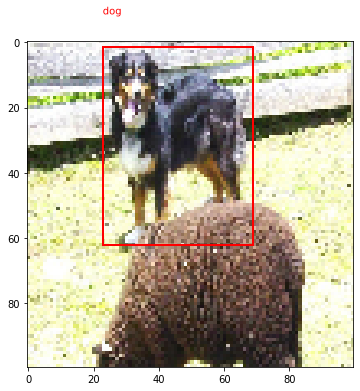

In [33]:
model.eval()
pred_bb_norm = model(img_tensor.to(device))[0].cpu().detach().numpy()
pred_bb = unnorm(pred_bb_norm, img.shape[:2])
plot_anns(img, (anns[0], [pred_bb]))
plt.show()

In [36]:
torch.save(model.state_dict(), "./models/localization_state_dict.pt")